# Data Preparation


In [1]:
import os 
import json

import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import transforms


from module.transforms import Standardize, Normalize, RandomFlip, RandomRotate, RandomRotate90, ElasticDeformation, AdditiveGaussianNoise, AdditivePoissonNoise, ToTensor
from module.utils import calculate_metrics, display_image_in_detail, plot_2d_data, display_4d_image, timer_decorator
from module.datasets import load_4d_dicom, save_4d_dicom, restore_data

from tqdm.notebook import tqdm
import h5py


In [ ]:
#
data_dir = "./dataset/10_05_2021_PET_only/PT_20p 150_120 OSEM"

#
real_data = load_4d_dicom(data_dir)
print(f"Loaded...{os.path.basename(data_dir)} {real_data.dtype} (shape:{real_data.shape}; range:[{np.min(real_data)},{np.max(real_data)}]; mean:{np.mean(real_data)}; std:{np.std(real_data)})")
display_4d_image(real_data)

## Option 1: Real-world Noise Dataset

In [ ]:
#
norm_slices = (real_data - np.mean(real_data)) / np.std(real_data)

min_val = np.min(norm_slices)
max_val = np.max(norm_slices)

norm_slices = (norm_slices - np.min(norm_slices)) / (np.max(norm_slices) - np.min(norm_slices))


# nessary info for restored 
restore_info = {'mean': np.mean(real_data).item(),
             'std': np.std(real_data).item(),
             'min': min_val.item(),
             'max': max_val.item()}


print(restore_info)


# save real noise dataset
file_name = f"{os.path.basename(data_dir)}_real"
with h5py.File(f'./dataset/preprocessed/{file_name}.h5', 'w') as f:
    f.create_dataset('dataset', data=norm_slices)
    f.create_dataset('restore_info', data=np.array(json.dumps(restore_info), dtype=h5py.string_dtype()))

## Option 2: Synthetic Noise Dataset

### 2.1 Prepare gaussian nosie dataset

In [ ]:
# example
norm_slices = (real_data - np.mean(real_data)) / np.std(real_data)
norm_slices = (norm_slices - np.min(norm_slices)) / (np.max(norm_slices) - np.min(norm_slices))

#
rs = np.random.RandomState(seed=80)


clean_image = norm_slices[11, 38]
noisy_image = AdditiveGaussianNoise(rs, scale=(0.009, 0.009), execution_probability=1.0)(norm_slices)[11, 38]


#
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
ax = axes.ravel()

ax[0].set_axis_off()
ax[0].imshow(clean_image, cmap='hot')
ax[0].set_title("origin")

ax[1].set_axis_off()
ax[1].imshow(noisy_image, cmap='hot')
ax[1].set_title("noisy")

ax[2].set_axis_off()
ax[2].imshow(noisy_image - clean_image, cmap='hot')
ax[2].set_title("diff")

In [ ]:
#
norm_slices = (real_data - np.mean(real_data)) / np.std(real_data)

min_val = np.min(norm_slices)
max_val = np.max(norm_slices)

norm_slices = (norm_slices - np.min(norm_slices)) / (np.max(norm_slices) - np.min(norm_slices))


# nessary info for restored 
restore_info = {'mean': np.mean(real_data).item(),
             'std': np.std(real_data).item(),
             'min': min_val.item(),
             'max': max_val.item()}

print(restore_info)

gaussian_scales = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009]

# save gussian noise dataset
rs = np.random.RandomState(seed=80)
for scale in tqdm(gaussian_scales, desc='Processing'):
    noisy_slices = AdditiveGaussianNoise(rs, scale=(scale, scale), execution_probability=1.0)(norm_slices)
    file_name = f"{os.path.basename(data_dir)}_gauss_{scale}"
    with h5py.File(f'./dataset/preprocessed/{file_name}.h5', 'w') as f:
        f.create_dataset('dataset', data=noisy_slices)
        f.create_dataset('restore_info', data=np.array(json.dumps(restore_info), dtype=h5py.string_dtype()))
    

### 2.2 Prepare poission noise dataset

In [ ]:
# example
norm_slices = (real_data - np.mean(real_data)) / np.std(real_data)
#norm_slices = (norm_slices - np.min(norm_slices)) / (np.max(norm_slices) - np.min(norm_slices))

print(f"norm_slices {norm_slices.shape} range:{(np.min(norm_slices), np.max(norm_slices))} mean:{np.mean(norm_slices)} std:{np.std(norm_slices)}")

#
rs = np.random.RandomState(seed=80)

#
clean_image = norm_slices[11, 38]
noisy_image = AdditivePoissonNoise(rs, lam=(0.9, 0.9), execution_probability=1.0)(norm_slices)[11, 38]

#
print(f"noisy_image {noisy_image.shape} range:{(np.min(noisy_image), np.max(noisy_image))} mean:{np.mean(noisy_image)} std:{np.std(noisy_image)}")
noisy_image = (noisy_image - np.min(noisy_image)) / (np.max(noisy_image) - np.min(noisy_image))
print(f"noisy_image {noisy_image.shape} range:{(np.min(noisy_image), np.max(noisy_image))} mean:{np.mean(noisy_image)} std:{np.std(noisy_image)}")

#
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
ax = axes.ravel()

ax[0].set_axis_off()
ax[0].imshow(clean_image, cmap='hot')
ax[0].set_title("origin")

ax[1].set_axis_off()
ax[1].imshow(noisy_image, cmap='hot')
ax[1].set_title("noisy")

ax[2].set_axis_off()
ax[2].imshow(noisy_image - clean_image, cmap='hot')
ax[2].set_title("diff")

In [ ]:
norm_slices = (real_data - np.mean(real_data)) / np.std(real_data)

min_val = np.min(norm_slices)
max_val = np.max(norm_slices)

#norm_slices = (norm_slices - np.min(norm_slices)) / (np.max(norm_slices) - np.min(norm_slices))


# nessary info for restored 
restore_info = {'mean': np.mean(real_data).item(),
             'std': np.std(real_data).item(),
             'min': min_val.item(),
             'max': max_val.item()}

print(restore_info)

poission_lams = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#poission_lams = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

# save gussian noise dataset
rs = np.random.RandomState(seed=80)
for lam in tqdm(poission_lams, desc='Processing'):
    noisy_slices = AdditivePoissonNoise(rs, lam=(lam, lam), execution_probability=1.0)(norm_slices)
    noisy_slices = (noisy_slices - np.min(noisy_slices)) / (np.max(noisy_slices)-np.min(noisy_slices))
    file_name = f"{os.path.basename(data_dir)}_poiss_{lam}"
    with h5py.File(f'./dataset/preprocessed/{file_name}.h5', 'w') as f:
        f.create_dataset('dataset', data=noisy_slices)
        f.create_dataset('restore_info', data=np.array(json.dumps(restore_info), dtype=h5py.string_dtype()))

### Option 3 : Data Augmentation

#### load data

In [2]:
# 
data_dir = "./dataset/10_05_2021_PET_only/PT_20p 150_120 OSEM"

real_data = load_4d_dicom(data_dir)

print(f"real_data: {real_data.dtype} (shape:{real_data.shape}; range:[{np.min(real_data)},{np.max(real_data)}]; mean:{np.mean(real_data)}; std:{np.std(real_data)})")

real_data: int16 (shape:(24, 71, 192, 192); range:[-32767,32767]; mean:201.12048776036573; std:1412.4139804758772)


### process data augmentation

In [3]:
def process_volume(volume, rs):
    """
    Applies specific augmentations (random rotation and elastic deformation) to a 3D volume.

    Args:
        volume (numpy.ndarray): The input 3D volume.
        rs (numpy.random.RandomState): The random state for ensuring consistency.

    Returns:
        numpy.ndarray: The augmented 3D volume.
    """
    # random_roate
    random_rotate90 = RandomRotate90(rs) 
    # elastic deformation
    elastic_deformation = ElasticDeformation(rs, 3, alpha=20, sigma=3, execution_probability=1.0)
    # 
    auged_volume = random_rotate90(volume)
    auged_volume = elastic_deformation(auged_volume)
    return auged_volume

@timer_decorator
def process_batch(data, batch_size, seed):
    """
    Applies data augmentation to a given 4D dataset and returns the augmented data along with the original data.

    Args:
        data (numpy.ndarray): The input data with shape (time, depth, height, width).
        batch_size (int): The number of additional augmented batches required.
        seed (int): The random seed for ensuring consistency in augmentation.

    Returns:
        numpy.ndarray: The augmented data with shape (batch_size+1, time, depth, height, width).
    """
    
    time, depth, height, width = data.shape
    augmented_data = np.zeros((batch_size+1, time, depth, height, width), dtype=data.dtype)
    augmented_data[0]=data # add original data in first batch 
    for batch in range(1, batch_size+1):
        # Create a random state for this batch and use it consistently across the entire time sequence
        for t in range(time):
            rs = np.random.RandomState(seed + batch)
            augmented_data[batch, t] = process_volume(data[t], rs)
    
    return augmented_data
    


In [4]:
# 
batch_data = process_batch(real_data, batch_size=10, seed=42)
print(f"batch_data\n dtype:{batch_data.dtype}\n range:({np.min(batch_data)}, {np.max(batch_data)})\n mean:{np.mean(batch_data)}\n std_dev:{np.std(batch_data)}")

process_batch running: 318.94883906375617 second
batch_data
 dtype:int16
 range:(-32768, 32767)
 mean:201.47672559617226
 std_dev:1407.3606500873764


### adding synthetic noise

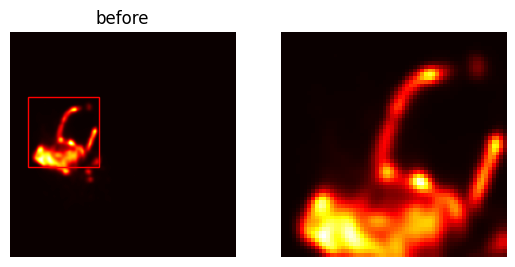

dtype:int16; range:(-5526, 32767); mean:173.69850887006064; std:1348.793186907172
add_noise running: 0.10715092904865742 second


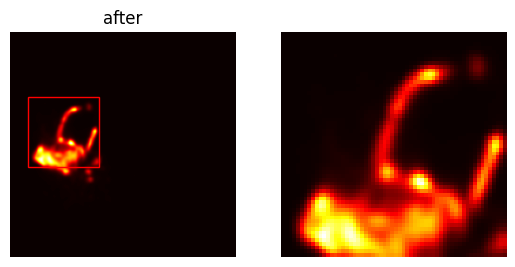

dtype:float32; range:(0.0, 1.0); mean:0.14884448051452637; std:0.03522297739982605


In [8]:
@timer_decorator
def add_noise(batch_data, noise_type, scale, lam):
    rs = np.random.RandomState(42)
    
    batch_data_float = batch_data.astype(np.float32)

    # z-score
    mean = batch_data_float.mean()
    std_dev = batch_data_float.std()

    z_scored_data = (batch_data_float - mean) / std_dev
    
    # normalize
    normalized_data = (z_scored_data - z_scored_data.min()) / (z_scored_data.max() - z_scored_data.min())
    
    # adding noise
    if noise_type == 'gaussian':
        add_gaussian_noise = AdditiveGaussianNoise(rs, scale=(scale, scale), execution_probability=1.0)
        noised_data = add_gaussian_noise(normalized_data)
    elif noise_type == 'poisson':
        add_poisson_noise = AdditivePoissonNoise(rs, lam=(lam, lam), execution_probability=1.0)
        noised_data = add_poisson_noise(normalized_data)
    else:
        raise ValueError("Invalid noise type. Choose 'gaussian' or 'poisson'.")

    

    #  restore information
    restore_info = {
        "original_min": batch_data_float.min(),
        "original_max": batch_data_float.max(),
        "z_score_mean": mean,
        "z_score_std_dev": std_dev,
        "noise_min": noised_data.min(),
        "noise_max": noised_data.max()
    }

    return normalized_data, restore_info



# exampple adding
test_volume = batch_data[0, 11]

display_image_in_detail(test_volume[38], title="before")
print(f"dtype:{test_volume.dtype}; range:({np.min(test_volume)}, {np.max(test_volume)}); mean:{np.mean(test_volume)}; std:{np.std(test_volume)}")

"""
mean=0
scale = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
lam = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
"""
noisy_volume, _ = add_noise(test_volume, noise_type="poisson", scale=0.50, lam=0.50)


display_image_in_detail(noisy_volume[38], title="after") 
print(f"dtype:{noisy_volume.dtype}; range:({np.min(noisy_volume)}, {np.max(noisy_volume)}); mean:{np.mean(noisy_volume)}; std:{np.std(noisy_volume)}")

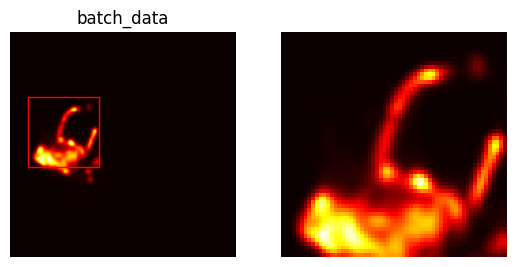

add_noise running: 39.86325897369534 second
noisy_batch
 dtype:float32
 range:(0.0, 1.0)
 mean:0.5030226111412048
 std_dev:0.02147510275244713


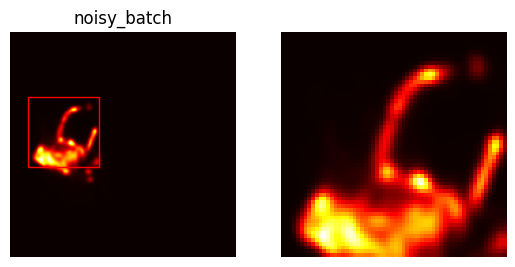

{'original_min': -32768.0, 'original_max': 32767.0, 'z_score_mean': 201.47107, 'z_score_std_dev': 1407.2665, 'noise_min': 0.0, 'noise_max': 9.500007629394531}


In [9]:
#
display_image_in_detail(batch_data[0, 11, 38], title="batch_data")


"""
gaussian
scale_list = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]
"""
"""
poisson
lam_list = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]
"""

#
#noise_type = "gaussian"
noise_type = "poisson"
noise_level = 0.50

#
noisy_batch, restore_info = add_noise(batch_data, noise_type=noise_type, scale=noise_level, lam=noise_level)

noisy_batch = noisy_batch.astype(np.float32)

print(f"noisy_batch\n dtype:{noisy_batch.dtype}\n range:({np.min(noisy_batch)}, {np.max(noisy_batch)})\n mean:{np.mean(noisy_batch)}\n std_dev:{np.std(noisy_batch)}")
display_image_in_detail(noisy_batch[0, 11, 38], title="noisy_batch")

print(restore_info)

### save as .h5 file

In [ ]:
# file_name = f"{os.path.basename(data_dir)}_{noise_type}_{noise_level:.2f}_batch"

file_name = f"{os.path.basename(data_dir)}_real_{noise_level:.2f}_batch"
print(file_name)

In [ ]:
restore_info_standard_types = {key: float(value) for key, value in restore_info.items()}
json_str = json.dumps(restore_info_standard_types)

with h5py.File(f'./dataset/preprocessed/{file_name}.h5', 'w') as f:
    f.create_dataset('dataset', data=noisy_batch)
    f.create_dataset('restore_info', data=np.array(json_str, dtype=h5py.string_dtype()))

### restore example

In [ ]:
file_name = './dataset/preprocessed/PT_20p 150_120 OSEM_real_0.00_batch.h5'

with h5py.File(file_name, 'r') as f:
    restore_info = json.loads(f['restore_info'][()])

In [ ]:
restored_data = restore_data(noisy_batch, restore_info)
print(f"restore_data: {restored_data.dtype} shape:{restored_data.shape}; range:({np.min(restored_data)},{np.max(restored_data)}); mean:{np.mean(restored_data)}; std:{np.std(restored_data)}")